In [1]:
from spectral import *
import spectral.io.envi as envi
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi




In [2]:
image = envi.open('../hyperImage/reflectance/MNF/MNF.HDR', '../hyperImage/reflectance/MNF/MNF')
img = image.load()


In [3]:
wavelength=envi.read_envi_header('../hyperImage/reflectance/MNF/MNF.hdr')

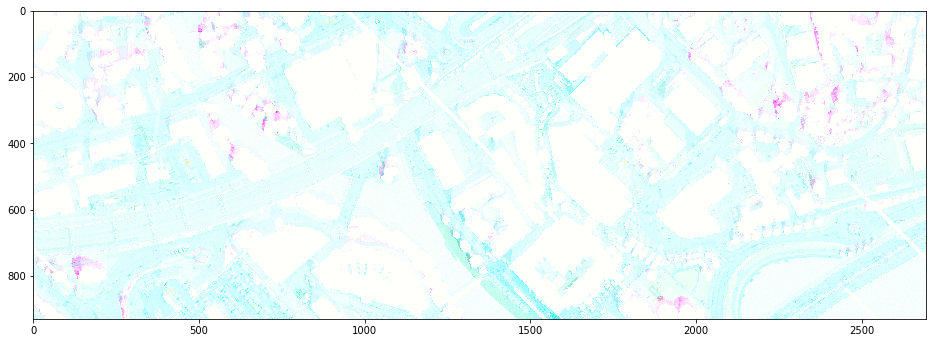

In [4]:
view = imshow(img, (1, 2, 3), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)), figsize=(16, 16))

In [5]:
img_mnf = img[:,:, :11]
img_mnf.shape

(930, 2694, 11)

In [6]:
## Combine PCA,and ndvi DATA
df_mnf = pd.DataFrame(img_mnf.reshape(-1, img_mnf.shape[2]))
string = "MNF"
df_mnf.columns = [string + str(n) for n in range(1, img_mnf.shape[2]+1)]

#Concatenate 3 dataframe 
main_df = pd.concat([df_mnf], axis=1, sort=False)

In [7]:
main_df.shape

(2505420, 11)

In [8]:
## Class image
gt_data = Image.open('../hyperImage/reflectance/roi/class4.tif')

gt = np.array(gt_data)
gt.shape

(930, 2694)

In [9]:
np.unique(gt)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [10]:
df_class = pd.DataFrame(gt.reshape(-1, 1))
string = "Target"
df_class.columns = [string]

# Using only hyperspectral data 

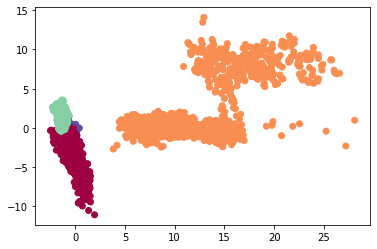

In [11]:
df = pd.concat([main_df, df_class], axis=1, sort=False)
df_masked = df[(df[['Target']] != 0).all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Spectral')
plt.show()

In [12]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)

In [25]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [6, 7],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [26]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   28.4s


KeyboardInterrupt: 

In [14]:
random_forest = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=4, n_jobs= -1)
random_forest.fit(X_train, y_train)
pred = random_forest.predict(X_test)
accuracy_score(y_test, pred)

0.9957412523020258

In [15]:
random_forest2 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=4, n_jobs= -1)
random_forest2.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=110, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [16]:
X_data = df.drop(columns=['Target']).values
X_data_scaled = scaler.transform(X_data)

In [17]:
y_pred = random_forest2.predict(X_data_scaled)

In [18]:
predicted_hsi_mask = y_pred.reshape(img.shape[0], img.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-44.106544494628906, 1.014676809310913]
    G: [-30.42329216003418, 1.0242762565612793]
    B: [-97.76713562011719, 1.0443428754806519]
>

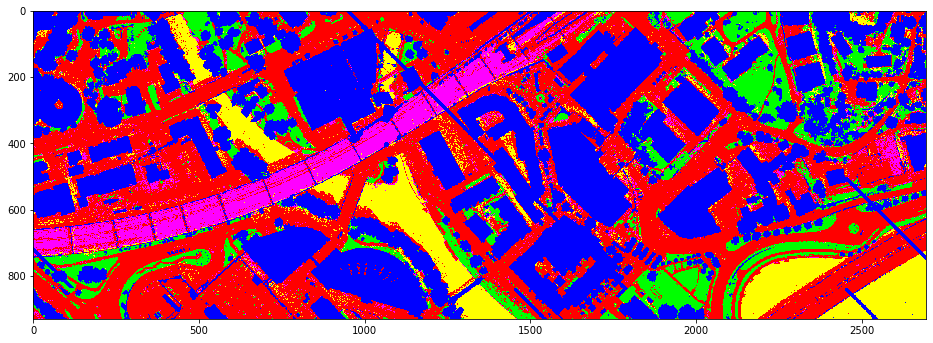

In [19]:
#full_image = envi.open('../hyperImage/reflectance/09_VNIR_POLISHED.hdr', '../hyperImage/reflectance/09_VNIR_POLISHED')
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [20]:
road = (predicted_hsi_mask == 1).astype(int)

In [58]:
from shapely.geometry import Polygon
from centerline.geometry import Centerline

In [59]:
polygon = road
attributes = {"id": 1, "name": "polygon", "valid": True}

In [61]:
type(road)

numpy.ndarray

In [60]:
centerline = Centerline(polygon, **attributes)
centerline.id == 1

InvalidInputTypeError: Input geometry must be of type shapely.geometry.Polygon or shapely.geometry.MultiPolygon!

In [21]:
from skimage.feature import canny
from skimage.viewer import ImageViewer
from skimage import io
from skimage import img_as_uint
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.3,
)
#viewer = ImageViewer(edges)
#viewer.show()
road_edges = edges.astype(int)


/opt/anaconda3/lib/python3.7/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-44.106544494628906, 1.014676809310913]
    G: [-30.42329216003418, 1.0242762565612793]
    B: [-97.76713562011719, 1.0443428754806519]
>

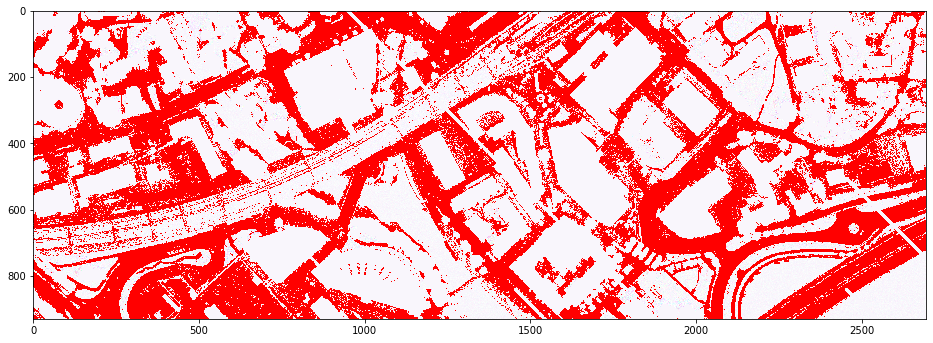

In [57]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Using Lidar Data Only

In [23]:
#import lidar dem and intensity image 
l_intensity_data = Image.open('../hyperImage/reflectance/roi/intensity.tif')
l_intensity = np.array(l_intensity_data)
df_intensity = pd.DataFrame(l_intensity.reshape(-1, 1))
string = "Lidar Intensity"
df_intensity.columns = [string]

l_dsm_data = Image.open('../hyperImage/reflectance/roi/dem.tif')
l_dsm = np.array(l_dsm_data)
df_dsm = pd.DataFrame(l_dsm.reshape(-1, 1))
string = "Lidar nDSM"
df_dsm.columns = [string]

In [24]:
df_lidar = pd.concat([df_intensity, df_dsm, df_class], axis=1, sort=False)
df_lidar_masked =  df_lidar[(df_lidar[['Target']] != 0).all(axis=1)]
X = df_lidar_masked.drop(columns=['Target']).values
y = df_lidar_masked['Target'].values

In [25]:
df_dsm.shape

(2505420, 1)

In [26]:
scaler1 = MinMaxScaler()
scaler1.fit(X)
X_scaled = scaler1.transform(X)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)

In [28]:
random_forest2 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest2.fit(X_train, y_train)
pred = random_forest2.predict(X_test)
accuracy_score(y_test, pred)

0.5011510128913443

In [29]:
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=110, max_features=0.25, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [30]:
X_lidar_data = df_lidar.drop(columns=['Target']).values
S_lidar_data_scaled = scaler1.transform(X_lidar_data)
y_pred_lidar = random_forest3.predict(S_lidar_data_scaled)
predicted_lidar_mask = y_pred_lidar.reshape(930, 2694)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-44.106544494628906, 1.014676809310913]
    G: [-30.42329216003418, 1.0242762565612793]
    B: [-97.76713562011719, 1.0443428754806519]
>

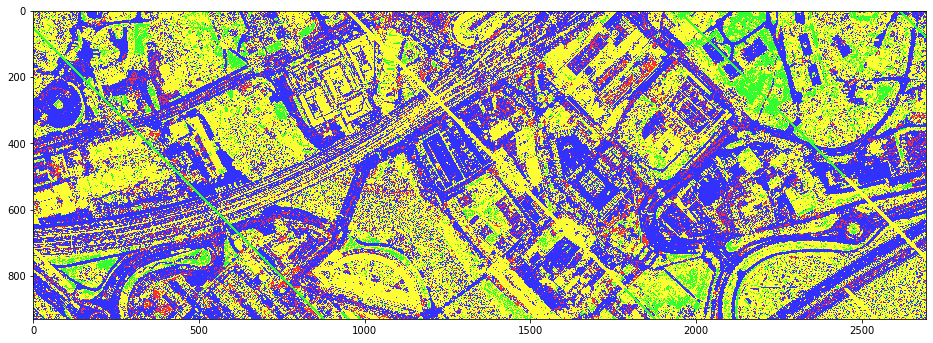

In [31]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 0.8
view.show_data

In [32]:
road = (predicted_lidar_mask == 3).astype(int)

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.3,
)

road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-44.106544494628906, 1.014676809310913]
    G: [-30.42329216003418, 1.0242762565612793]
    B: [-97.76713562011719, 1.0443428754806519]
>

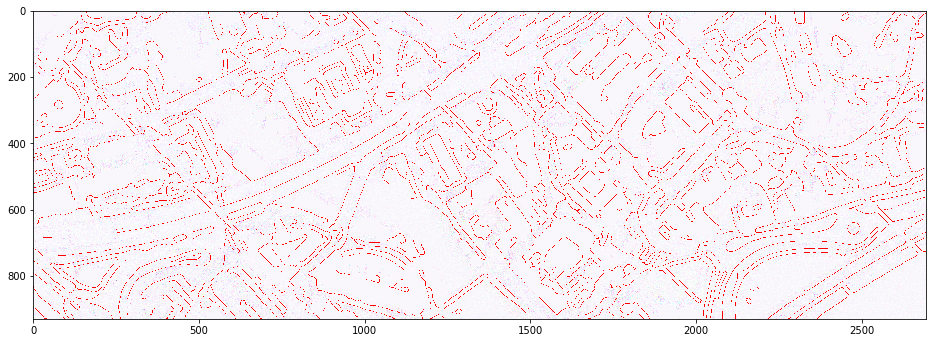

In [34]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Using  hyperspectral and lidar data 

In [35]:
#merge with HSI dataframe and lidar dataframe

In [36]:
df_lid_hsi = pd.concat([main_df, df_intensity, df_dsm, df_class], axis=1, sort=False)

In [37]:
df_masked =  df_lid_hsi[(df_lid_hsi[['Target']] != 0).all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values

In [38]:
scaler3 = MinMaxScaler()
scaler3.fit(X)
X_scaled = scaler3.transform(X)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_train, y_train)
pred = random_forest3.predict(X_test)
accuracy_score(y_test, pred)

0.9965469613259669

In [40]:
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=110, max_features=0.25, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [41]:
X_data = df_lid_hsi.drop(columns=['Target']).values
X_data_scaled = scaler3.transform(X_data)

In [42]:
y_pred = random_forest3.predict(X_data_scaled)

In [43]:
predicted_hsi_lidar_mask = y_pred.reshape(930, 2694)

In [44]:
road = (predicted_hsi_lidar_mask == 1).astype(int)

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.4,
)
road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-44.106544494628906, 1.014676809310913]
    G: [-30.42329216003418, 1.0242762565612793]
    B: [-97.76713562011719, 1.0443428754806519]
>

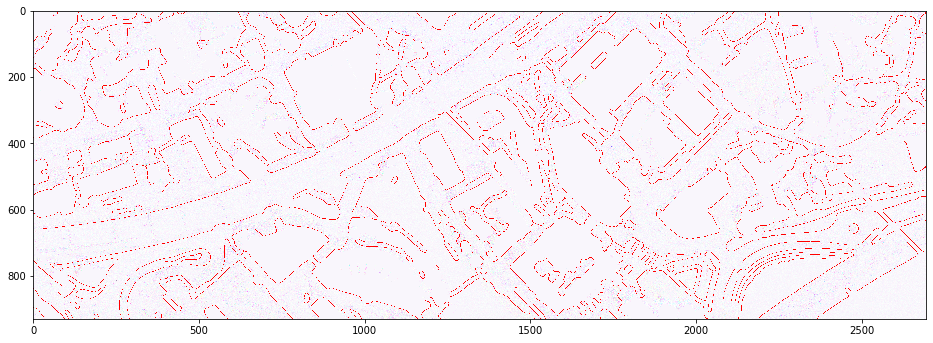

In [46]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-44.106544494628906, 1.014676809310913]
    G: [-30.42329216003418, 1.0242762565612793]
    B: [-97.76713562011719, 1.0443428754806519]
>

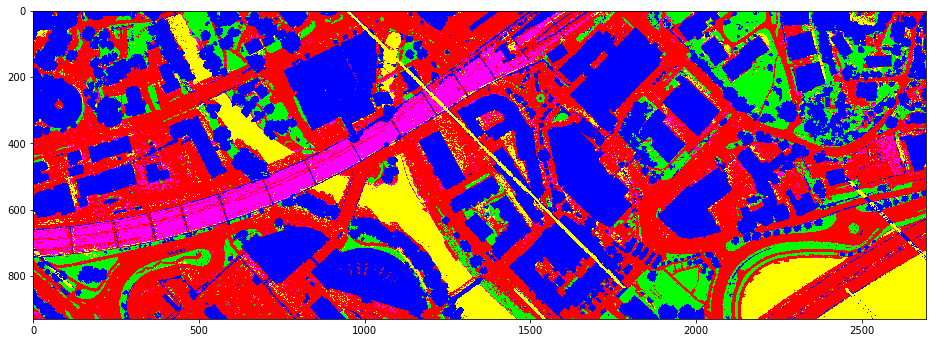

In [47]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Validation data

In [51]:
val_image = envi.open('../hyperImage/reflectance/MNF/mnf_08_val.hdr', '../hyperImage/reflectance/MNF/mnf_08_val')
val_img = val_image.load()
val_img.shape

(764, 1821, 11)

In [52]:
l_intensity_data = Image.open('../hyperImage/reflectance/vnir/intensity.tif')
l_intensity = np.array(l_intensity_data)
df_intensity = pd.DataFrame(l_intensity.reshape(-1, 1))
string = "Lidar Intensity"
df_intensity.columns = [string]

l_dsm_data = Image.open('../hyperImage/reflectance/vnir/nDSM.tif')
l_dsm = np.array(l_dsm_data)
df_dsm = pd.DataFrame(l_dsm.reshape(-1, 1))
string = "Lidar nDSM"
df_dsm.columns = [string]

In [53]:
## Combine PCA,and ndvi DATA
df_val = pd.DataFrame(val_img.reshape(-1, val_img.shape[2]))
string = "MNF"
df_val.columns = [string + str(n) for n in range(1, val_img.shape[2]+1)]
#Concatenate 3 dataframe 
main_df = pd.concat([df_val], axis=1, sort=False)

In [54]:
df_lid_hsi = pd.concat([main_df, df_intensity, df_dsm], axis=1, sort=False)

In [55]:
df_lid_hsi

MNF1      MNF2      MNF3      MNF4     MNF5      MNF6      MNF7  \
0        0.736076 -2.635963 -0.302159 -0.780034 -0.01938  0.215601  0.135424   
1        0.736076 -2.635963 -0.302159 -0.780034 -0.01938  0.215601  0.135424   
2        0.736076 -2.635963 -0.302159 -0.780034 -0.01938  0.215601  0.135424   
3        0.736076 -2.635963 -0.302159 -0.780034 -0.01938  0.215601  0.135424   
4        0.736076 -2.635963 -0.302159 -0.780034 -0.01938  0.215601  0.135424   
...           ...       ...       ...       ...      ...       ...       ...   
1834499       NaN       NaN       NaN       NaN      NaN       NaN       NaN   
1834500       NaN       NaN       NaN       NaN      NaN       NaN       NaN   
1834501       NaN       NaN       NaN       NaN      NaN       NaN       NaN   
1834502       NaN       NaN       NaN       NaN      NaN       NaN       NaN   
1834503       NaN       NaN       NaN       NaN      NaN       NaN       NaN   

             MNF8      MNF9     MNF10     MNF11  Lidar Intensity  Lidar nDSM  
0       -0.164676 -0.051787  0.230828  0.122733             15.0   29.950001  
1       -0.164676 -0.051787  0.230828  0.122733             16.0   29.950001  
2       -0.164676 -0.051787  0.230828  0.122733             14.0   29.969999  
3       -0.164676 -0.051787  0.230828  0.122733             15.0   29.940001  
4       -0.164676 -0.051787  0.230828  0.122733             15.0   29.940001  
...           ...       ...       ...       ...              ...         ...  
1834499       NaN       NaN       NaN       NaN             18.0    0.139999  
1834500       NaN       NaN       NaN       NaN             25.0    0.139999  
1834501       NaN       NaN       NaN       NaN             16.0    0.120000  
1834502       NaN       NaN       NaN       NaN              8.0    0.000000  
1834503       NaN       NaN       NaN       NaN              6.0    0.000000  

[1834504 rows x 13 columns]

In [66]:
X_data_scaled = scaler3.transform(df_lid_hsi)

In [67]:
val_pred_full = random_forest3.predict(X_data_scaled)

In [68]:
predicted_hsi_lidar_mask_val = val_pred_full.reshape(val_image.shape[0], val_image.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [9.0, 1374.0]
    G: [7.0, 1732.0]
    B: [0.0, 822.0]
>

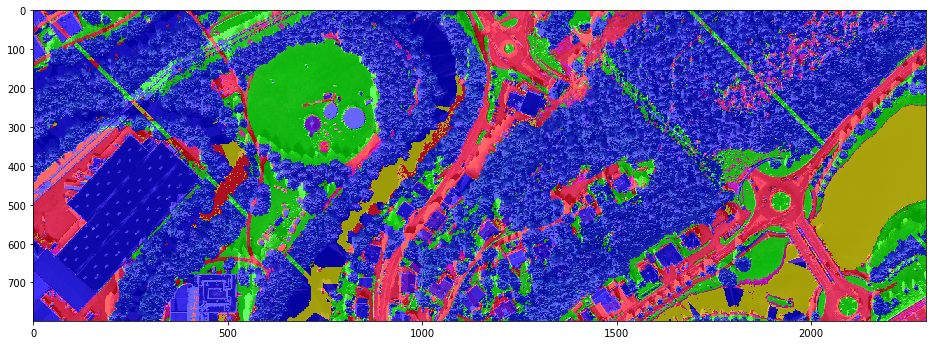

In [75]:
view = imshow(val_full_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 0.6
view.show_data

In [70]:
road = (predicted_hsi_lidar_mask_val == 1).astype(int)

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.4,
)
road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


In [72]:
val_full_image = envi.open('../hyperImage/reflectance/vnir/08_clipped.hdr', '../hyperImage/reflectance/vnir/08_clipped.')

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [9.0, 1374.0]
    G: [7.0, 1732.0]
    B: [0.0, 822.0]
>

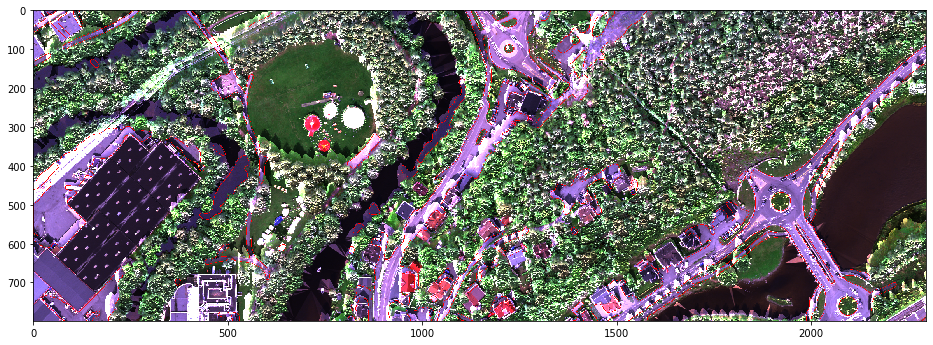

In [73]:
view = imshow(val_full_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data